In [83]:
import json
import pandas as pd
import numpy as np
import sqlite3
from scipy import stats

In [84]:
file_path_receipts = "/Users/yangzhe1/Downloads/receipts.json"
file_path_users = "/Users/yangzhe1/Downloads/users.json"
file_path_brands = "/Users/yangzhe1/Downloads/brands.json"

# Convert to dict
receipts = []
users = []
brands = []
with open(file_path_receipts, "r", encoding="utf-8") as f:
    for line in f:
        receipts.append(json.loads(line.strip())) 

with open(file_path_users, "r", encoding="utf-8") as f:
    for line in f:
        users.append(json.loads(line.strip()))  

with open(file_path_brands, "r", encoding="utf-8") as f:
    for line in f:
        brands.append(json.loads(line.strip()))  


In [85]:
# Convert to DataFrame
receipts = pd.DataFrame(receipts)
users = pd.DataFrame(users)
brands = pd.DataFrame(brands)

## First: Review Existing Unstructured Data and Diagram a New Structured Relational Data Model

# receipts dataframe

In [86]:
# Expand nested field

receipts["rewardsReceiptItemList"] = receipts["rewardsReceiptItemList"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
receipts["rewardsReceiptItemList"].fillna("[]", inplace=True)
# Explode list into multiple rows
receipts_explode = receipts.explode("rewardsReceiptItemList")
# Normalize into separate columns
receipts_normalized = pd.json_normalize(receipts_explode["rewardsReceiptItemList"])
#
receipts_normalized.columns = [f"rewardsReceiptItemList_{col}" for col in receipts_normalized.columns]
# Merge columns back
receipts_final = receipts_explode.drop(columns = ["rewardsReceiptItemList"]).reset_index(drop = True)
receipts_final = pd.concat([receipts_final, receipts_normalized], axis = 1)

In [87]:
# Function to extract timestamp and convert to datetime

# Convert from milliseconds
def convert_mongo_date(date_entry):
    if isinstance(date_entry, dict) and "$date" in date_entry:
        return pd.to_datetime(date_entry["$date"], unit="ms")  
    return pd.NaT

# Apply conversion to multiple columns
date_columns = ["createDate", "dateScanned", "finishedDate", "modifyDate", "pointsAwardedDate", "purchaseDate"]  
for col in date_columns:
    receipts_final[col] = receipts_final[col].apply(convert_mongo_date)

In [88]:
# Convert 'ID" column into a usable string
# Extract the `$oid` value
receipts_final["_id"] = receipts_final["_id"].apply(lambda x: x["$oid"] if isinstance(x, dict) and "$oid" in x else None)

In [89]:
receipts_final.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId,rewardsReceiptItemList_barcode,rewardsReceiptItemList_description,rewardsReceiptItemList_finalPrice,rewardsReceiptItemList_itemPrice,rewardsReceiptItemList_needsFetchReview,rewardsReceiptItemList_partnerItemId,rewardsReceiptItemList_preventTargetGapPoints,rewardsReceiptItemList_quantityPurchased,rewardsReceiptItemList_userFlaggedBarcode,rewardsReceiptItemList_userFlaggedNewItem,rewardsReceiptItemList_userFlaggedPrice,rewardsReceiptItemList_userFlaggedQuantity,rewardsReceiptItemList_needsFetchReviewReason,rewardsReceiptItemList_pointsNotAwardedReason,rewardsReceiptItemList_pointsPayerId,rewardsReceiptItemList_rewardsGroup,rewardsReceiptItemList_rewardsProductPartnerId,rewardsReceiptItemList_userFlaggedDescription,rewardsReceiptItemList_originalMetaBriteBarcode,rewardsReceiptItemList_originalMetaBriteDescription,rewardsReceiptItemList_brandCode,rewardsReceiptItemList_competitorRewardsGroup,rewardsReceiptItemList_discountedItemPrice,rewardsReceiptItemList_originalReceiptItemText,rewardsReceiptItemList_itemNumber,rewardsReceiptItemList_originalMetaBriteQuantityPurchased,rewardsReceiptItemList_pointsEarned,rewardsReceiptItemList_targetPrice,rewardsReceiptItemList_competitiveProduct,rewardsReceiptItemList_originalFinalPrice,rewardsReceiptItemList_originalMetaBriteItemPrice,rewardsReceiptItemList_deleted,rewardsReceiptItemList_priceAfterCoupon,rewardsReceiptItemList_metabriteCampaignId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,FINISHED,26.00,5ff1e1eacfcf6c399c274ae6,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,True,26.00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,True,2,True,1.0,028400642255,True,10.00,1.0,USER_FLAGGED,Action not allowed for user and CPG,5332f5fbe4b03c9a25efd0ba,DORITOS SPICY SWEET CHILI SINGLE SERVE,5332f5fbe4b03c9a25efd0ba,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03 15:25:37,2021-01-03 15:25:37,NaT,2021-01-03 15:25:42,NaT,5,2021-01-03 00:00:00,1.0,REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b,NaN,NaN,NaN,NaN,False,1,True,NaN,4011,True,26.00,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,FINISHED,28.00,5ff1e1eacfcf6c399c274ae6,4011,ITEM NOT FOUND,28.00,28.00,False,1,True,4.0,4011,True,28.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# users dataframe

In [90]:
# Apply date and time conversion to multiple columns
date_columns_users = ["createdDate", "lastLogin"]  
for col in date_columns_users:
    users[col] = users[col].apply(convert_mongo_date)

In [91]:
# Convert '_ID" column into a usable string
# Extract the `$oid` value
users["_id"] = users["_id"].apply(lambda x: x["$oid"] if isinstance(x, dict) and "$oid" in x else None)

In [92]:
users.head()

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30.554,2021-01-03 15:25:30.597,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI


# brands dataframe

In [93]:
# Expand nested field

brands["cpg"] = brands["cpg"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
# Normalize into separate columns
brands_normalized = pd.json_normalize(brands["cpg"])
brands_normalized.columns = [f"cpg_{col}" for col in brands_normalized.columns]
# Merge columns back
brands_final = brands.drop(columns = ["cpg"]).reset_index(drop = True)
brands_final = pd.concat([brands_final, brands_normalized], axis = 1)

In [94]:
# Convert '_ID" column into a usable string
# Extract the `$oid` value
brands_final["_id"] = brands_final["_id"].apply(lambda x: x["$oid"] if isinstance(x, dict) and "$oid" in x else None)

In [95]:
brands_final.head()

,_id,barcode,category,categoryCode,name,topBrand,brandCode,cpg_$ref,cpg_$id.$oid
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,test brand @1612366101024,False,NaN,Cogs,601ac114be37ce2ead437550
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,Starbucks,False,STARBUCKS,Cogs,5332f5fbe4b03c9a25efd0ba
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,test brand @1612366146176,False,TEST BRANDCODE @1612366146176,Cogs,601ac142be37ce2ead437559
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,test brand @1612366146051,False,TEST BRANDCODE @1612366146051,Cogs,601ac142be37ce2ead437559
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,test brand @1612366146827,False,TEST BRANDCODE @1612366146827,Cogs,5332fa12e4b03c9a25efd1e7


## Second: Write queries that directly answer predetermined questions from a business stakeholder

In [96]:
# Create a connection to SQL
conn = sqlite3.connect(":memory:")
# Convert columns to supported types
receipts_final = receipts_final.astype(str)
brands_final = brands_final.astype(str)
users = users.astype(str)
receipts_final["dateScanned"] = pd.to_datetime(receipts_final["dateScanned"]).dt.strftime("%Y-%m-%d")
users["createdDate"] = pd.to_datetime(users["createdDate"]).dt.strftime("%Y-%m-%d")
# Store DataFrame as an SQL table
receipts_final.to_sql("receipts_final", conn, index=False, if_exists="replace")
brands_final.to_sql("brands_final", conn, index=False, if_exists="replace")
users.to_sql("users", conn, index=False, if_exists="replace")


495

What are the top 5 brands by receipts scanned for most recent month?

In [97]:
query_1 = """
SELECT r.rewardsReceiptItemList_brandCode AS Top_5_brands, COUNT(r._id) AS Scanned_times
FROM receipts_final AS r 
WHERE r.dateScanned BETWEEN (SELECT DATE(MAX(dateScanned), '-1 month') FROM receipts_final)
      AND 
      (SELECT MAX(dateScanned) FROM receipts_final)
GROUP BY r.rewardsReceiptItemList_brandCode
ORDER BY COUNT(r._id) DESC
LIMIT 5
"""

result_1 = pd.read_sql(query_1, conn)
print(result_1)

  Top_5_brands  Scanned_times
0          nan            552
1        BRAND              3
2      MISSION              2
3         VIVA              1


How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?

In [98]:
query_2 = """
SELECT *
FROM (SELECT r.rewardsReceiptItemList_brandCode AS Top_5_brands, COUNT(r._id) AS Scanned_times, "current_month" AS Month, ROW_NUMBER() OVER (ORDER BY COUNT(r._id) DESC) AS Rankings
FROM receipts_final AS r 
WHERE r.dateScanned BETWEEN (SELECT DATE(MAX(dateScanned), '-2 month') FROM receipts_final)
      AND 
      (SELECT DATE(MAX(dateScanned), '-1 month') FROM receipts_final)
GROUP BY r.rewardsReceiptItemList_brandCode
ORDER BY COUNT(r._id) DESC
LIMIT 5)

UNION ALL

SELECT *
FROM (
SELECT r.rewardsReceiptItemList_brandCode AS Top_5_brands, COUNT(r._id) AS Scanned_times, "prev_month" AS Month, ROW_NUMBER() OVER (ORDER BY COUNT(r._id) DESC) AS Rankings
FROM receipts_final AS r 
WHERE r.dateScanned BETWEEN (SELECT DATE(MAX(dateScanned), '-1 month') FROM receipts_final)
      AND 
      (SELECT MAX(dateScanned) FROM receipts_final)
GROUP BY r.rewardsReceiptItemList_brandCode
ORDER BY COUNT(r._id) DESC
LIMIT 5)
"""

result_2 = pd.read_sql(query_2, conn)
print(result_2)

     Top_5_brands  Scanned_times          Month  Rankings
0             nan           4187  current_month         1
1          HY-VEE            291  current_month         2
2  BEN AND JERRYS            180  current_month         3
3           PEPSI             93  current_month         4
4          KROGER             89  current_month         5
5             nan            552     prev_month         1
6           BRAND              3     prev_month         2
7         MISSION              2     prev_month         3
8            VIVA              1     prev_month         4


When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [99]:
query_3 = """
-- Creat a temporary table to make sure every receipt id only has one record
WITH receipt_sum AS (
SELECT _id, IFNULL(totalSpent, 0) AS total_spent, rewardsReceiptStatus
FROM receipts_final
WHERE rewardsReceiptStatus = "FINISHED" OR rewardsReceiptStatus = "REJECTED"
GROUP BY _id)

-- Calculate average spend
SELECT r.rewardsReceiptStatus AS Status, AVG(total_spent) AS Average_spend
FROM receipt_sum AS r 
GROUP BY r.rewardsReceiptStatus
"""

result_3 = pd.read_sql(query_3, conn)
print(result_3)

     Status  Average_spend
0  FINISHED      80.854305
1  REJECTED      23.326056


When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [100]:
query_4 = """
-- Creat a temporary table to make sure every receipt id only has one record
WITH receipt_sum AS (
SELECT _id, IFNULL(purchasedItemCount, 0) AS total_number_items, rewardsReceiptStatus
FROM receipts_final
WHERE rewardsReceiptStatus = "FINISHED" OR rewardsReceiptStatus = "REJECTED"
GROUP BY _id)

-- Calculate total number of items purchased
SELECT r.rewardsReceiptStatus AS Status, SUM(total_number_items) AS Total_number_of_items
FROM receipt_sum AS r 
GROUP BY r.rewardsReceiptStatus
"""

result_4 = pd.read_sql(query_4, conn)
print(result_4)

     Status  Total_number_of_items
0  FINISHED                 8184.0
1  REJECTED                  173.0


Which brand has the most spend among users who were created within the past 6 months?

In [101]:
query_5 = """
SELECT r.rewardsReceiptItemList_brandCode, SUM(IFNULL(totalSpent,0)) AS Total_spent
FROM receipts_final r 
JOIN users u ON r.userId = u._id
WHERE r.rewardsReceiptItemList_brandCode != "nan"
AND u.createdDate BETWEEN 
    (SELECT DATE(MAX(createdDate), '-6 month') FROM users)
    AND 
    (SELECT MAX(createdDate) FROM users)
GROUP BY r.rewardsReceiptItemList_brandCode
ORDER BY SUM(IFNULL(totalSpent,0)) DESC
LIMIT 1
"""

result_5 = pd.read_sql(query_5, conn)
print(result_5)

  rewardsReceiptItemList_brandCode  Total_spent
0                           HY-VEE    373558.41


## Third: Evaluate Data Quality Issues in the Data Provided

Check for missing values

In [102]:
# Count NaN values
missing_values = receipts_final.isna().sum()

# Count empty strings
empty_values = (receipts_final == "").sum()

# Count string "nan" (case-insensitive)
string_nan_values = receipts_final.apply(lambda col: col.astype(str).str.lower().eq("nan").sum())

# Combine all missing value counts
total_missing = missing_values + empty_values + string_nan_values

# Filter only columns where missing values exist
missing_columns = total_missing[total_missing > 0]

# Print missing values only
print(missing_columns)

bonusPointsEarned                                            1401
bonusPointsEarnedReason                                      1401
pointsEarned                                                 1128
purchasedItemCount                                            484
totalSpent                                                    435
rewardsReceiptItemList_barcode                               4291
rewardsReceiptItemList_description                            821
rewardsReceiptItemList_finalPrice                             614
rewardsReceiptItemList_itemPrice                              614
rewardsReceiptItemList_needsFetchReview                      6568
rewardsReceiptItemList_partnerItemId                          440
rewardsReceiptItemList_preventTargetGapPoints                7023
rewardsReceiptItemList_quantityPurchased                      614
rewardsReceiptItemList_userFlaggedBarcode                    7044
rewardsReceiptItemList_userFlaggedNewItem                    7058
rewardsRec

Check for Duplicates

In [103]:
# Count duplicate rows
print(receipts_final.duplicated().sum())  

0


Check for Outliers

<Axes: ylabel='totalSpent'>

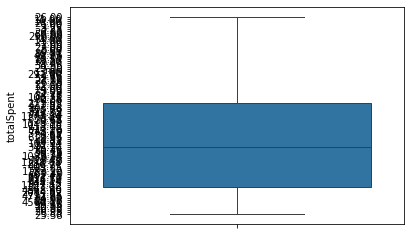

In [104]:
import seaborn as sns
# Visualize outliers
sns.boxplot(receipts_final['totalSpent'])  

<Axes: ylabel='pointsEarned'>

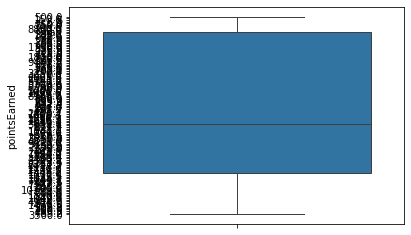

In [105]:
# Visualize outliers
sns.boxplot(receipts_final['pointsEarned'])  

In [107]:
# Calculate Z-score
receipts_final['totalSpent'] = pd.to_numeric(receipts_final['totalSpent'], errors='coerce')
receipts_final['Z_Score'] = np.abs(stats.zscore(receipts_final['totalSpent']))

# Identify outliers (Z-score > 3)
receipts_final['Outlier'] = receipts_final['Z_Score'] > 3

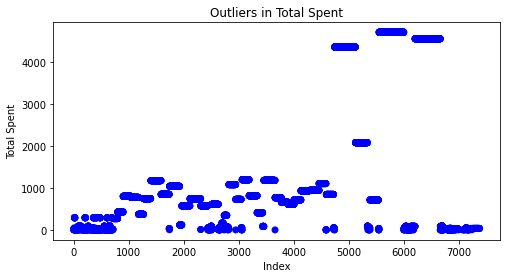

In [108]:
# Display outliers
plt.figure(figsize=(8, 4))
plt.scatter(receipts_final.index, receipts_final['totalSpent'], c=receipts_final['Outlier'].map({True: 'red', False: 'blue'}))
plt.xlabel("Index")
plt.ylabel("Total Spent")
plt.title("Outliers in Total Spent")
plt.show()